## Collect Model and Data

In [1]:
import os
import numpy as np
import random
import h5py
import sys
from decimal import Decimal
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import keras
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.layers import UpSampling2D, Cropping2D
from keras import models
from sklearn.metrics import accuracy_score

In [2]:
#download files in lab3/bd and lab3/cl
!gdown --id 1kxNACo0qFo8QdZgtGHvaA67p4h4RcNIy

!gdown --id 1HpahIi-RcvtaRoly_TbuoBzWUaAjVDgt

!gdown --id 1nbB5tyUVClSaFvvg3hrFW4wOUj3GtNTf



Downloading...
From: https://drive.google.com/uc?id=1kxNACo0qFo8QdZgtGHvaA67p4h4RcNIy
To: /content/bd_test.h5
100% 398M/398M [00:02<00:00, 158MB/s]
Downloading...
From: https://drive.google.com/uc?id=1HpahIi-RcvtaRoly_TbuoBzWUaAjVDgt
To: /content/test.h5
100% 398M/398M [00:02<00:00, 158MB/s]
Downloading...
From: https://drive.google.com/uc?id=1nbB5tyUVClSaFvvg3hrFW4wOUj3GtNTf
To: /content/valid.h5
100% 716M/716M [00:13<00:00, 53.9MB/s]


In [3]:
#load the oringal badnet
!git clone https://github.com/csaw-hackml/CSAW-HackML-2020.git

fatal: destination path 'CSAW-HackML-2020' already exists and is not an empty directory.


In [4]:
# !python3 CSAW-HackML-2020/lab3/eval.py /content/test.h5 /content/bd_test.h5 /content/CSAW-HackML-2020/lab3/models/bd_net.h5

### Load Data

In [5]:
def data_loader(filepath):
    data = h5py.File(filepath, 'r')
    x_data = np.array(data['data'])
    y_data = np.array(data['label'])
    x_data = x_data.transpose((0,2,3,1))

    return x_data, y_data
  
clean_valid_x, clean_valid_y = data_loader('/content/valid.h5')
clean_test_x, clean_test_y = data_loader('/content/test.h5')
bd_test_x, bd_test_y = data_loader('/content/bd_test.h5') 
biggest_class_value = int(clean_valid_y.max())
print(biggest_class_value)

1282


### Load Bad Net Model

In [6]:
bd_model = keras.models.load_model('/content/CSAW-HackML-2020/lab3/models/bd_net.h5')
#get original accuracy
pre_y = np.argmax(bd_model.predict(clean_test_x), axis=1)
original_acc = accuracy_score(pre_y, clean_test_y) *100
print(original_acc)


98.62042088854248


In [7]:
bd_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 55, 47, 3)]  0           []                               
                                                                                                  
 conv_1 (Conv2D)                (None, 52, 44, 20)   980         ['input[0][0]']                  
                                                                                                  
 pool_1 (MaxPooling2D)          (None, 26, 22, 20)   0           ['conv_1[0][0]']                 
                                                                                                  
 conv_2 (Conv2D)                (None, 24, 20, 40)   7240        ['pool_1[0][0]']                 
                                                                                            

# The accuracy and the attack success rate as a function of the fraction of channels pruned

In [8]:
gd_model = keras.models.clone_model(bd_model)
gd_model.set_weights(bd_model.get_weights())

#we need to drop one channel in conv_3 each time
conv_3 = gd_model.get_layer('conv_3')

intermediate = keras.Model(inputs=gd_model.input, outputs=gd_model.get_layer('conv_3').output)

activation_values = intermediate.predict(clean_valid_x).sum(axis=(0,1,2))
delete_channels_sort = np.argsort(activation_values)


channels = []
acc_list = []
count = 0
asr_list = []
three_drops_list = []
x_2,x_4,x_10 = 0,0,0
for i in range(len(delete_channels_sort)):
  count+=1
  if i % 2 == 0:# prevent RAM overflow, skip two at once
    new_channel = np.array(conv_3.get_weights()[0])
    new_channel[:, :, :, delete_channels_sort[i]] = np.zeros((3, 3, 40))
    conv_3.set_weights(list([new_channel, conv_3.get_weights()[1]]))
    continue
  if activation_values[delete_channels_sort[i]] < 1e-3:
    continue
  output_y = []
  new_channel = np.array(conv_3.get_weights()[0])
  new_channel[:, :, :, delete_channels_sort[i]] = np.zeros((3, 3, 40))
  conv_3.set_weights(list([new_channel, conv_3.get_weights()[1]]))

  #class acc, use clean test set
  pred_bd = np.argmax(bd_model.predict(clean_test_x), axis=1)
  pred_gd = np.argmax(gd_model.predict(clean_test_x), axis=1)
  for j in range(len(pred_bd)):
    if pred_bd[j] == pred_gd[j]:
      output_y.append(pred_bd[j])
    else:
      output_y.append(biggest_class_value+1)# output value N+1 of this image classification
  output_y = np.array(output_y)
  
  clean_accuracy = np.mean(np.equal(output_y,clean_test_y ))*100


  print('fraction is ',count/(len(delete_channels_sort)), ' Clean Classification accuracy:', clean_accuracy)
  channels.append(count/(len(delete_channels_sort)))
  acc_list.append(clean_accuracy)


  #attack success rate, use bad test set
  pred_bd = np.argmax(bd_model.predict(bd_test_x), axis=1)
  pred_gd = np.argmax(gd_model.predict(bd_test_x), axis=1)
  output_y_att = []
  for j in range(len(pred_bd)):
    if pred_bd[j] == pred_gd[j]:
      output_y_att.append(pred_bd[j])
    else:
      output_y_att.append(biggest_class_value+1)# output value N+1 of this image classification
  output_y_att = np.array(output_y_att)
  asr = np.mean(np.equal(output_y_att,bd_test_y ))*100
  asr_list.append(asr)
  print('Attack Success Rate:', asr)
  
   #output X={2%,4%,10%} models
  
  if original_acc - clean_accuracy > 2:
    if x_2 == 0:
      x_2 = 1
      three_drops_list.append((clean_accuracy,asr))
    else:
      if original_acc - clean_accuracy > 4:
        if x_4 == 0:
          x_4 = 1
          three_drops_list.append((clean_accuracy,asr))
        else:
          if original_acc - clean_accuracy > 10:
            if x_10 == 0:
              three_drops_list.append((clean_accuracy,asr))
              x_10 = 1


fraction is  0.5333333333333333  Clean Classification accuracy: 98.61262665627436
Attack Success Rate: 100.0
fraction is  0.5666666666666667  Clean Classification accuracy: 98.60483242400623
Attack Success Rate: 100.0
fraction is  0.6  Clean Classification accuracy: 98.58924395947
Attack Success Rate: 100.0
fraction is  0.6333333333333333  Clean Classification accuracy: 98.57365549493376
Attack Success Rate: 100.0
fraction is  0.6666666666666666  Clean Classification accuracy: 98.45674201091192
Attack Success Rate: 100.0
fraction is  0.7  Clean Classification accuracy: 98.0826188620421
Attack Success Rate: 100.0
fraction is  0.7333333333333333  Clean Classification accuracy: 97.54481683554171
Attack Success Rate: 100.0
fraction is  0.7666666666666667  Clean Classification accuracy: 95.47155105222136
Attack Success Rate: 99.97661730319564
fraction is  0.8  Clean Classification accuracy: 94.61418550272798
Attack Success Rate: 99.97661730319564
fraction is  0.8333333333333334  Clean Class

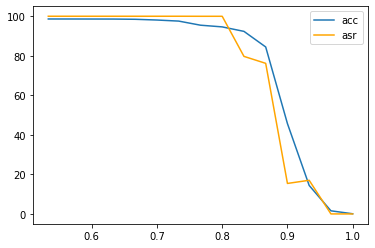

In [9]:

plt.plot(channels,acc_list,label = 'acc')
plt.plot(channels,asr_list,color = 'orange', label = 'asr')
plt.legend()

# Then acc and asr of drops in {2%,4%,10%}

In [10]:
#output the accuricy and asr when drops = {2%,4%,10%}

drops = [2,4,10]

for i in range(len(drops)):
  print('when the drops is ',drops[i], 'the acc of this G model is ',three_drops_list[i][0],'the asr of this G model is ',three_drops_list[i][1] )



when the drops is  2 the acc of this G model is  95.47155105222136 the asr of this G model is  99.97661730319564
when the drops is  4 the acc of this G model is  94.61418550272798 the asr of this G model is  99.97661730319564
when the drops is  10 the acc of this G model is  84.45830085736556 the asr of this G model is  76.1730319563523
